In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.tail(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
3748,21-03-2024,1035.599976,9903738,6715.750000,1806092,255.699997,10121220,149.949997,6212045,1445.750000,...,1772.150024,3783681,121.050003,38099730,744.299988,15161161,450.250000,18429233,841.599976,987716
3749,22-03-2024,1033.300049,9891194,6760.899902,1125238,259.799988,11402546,149.600006,8409218,1442.849976,...,1776.400024,7061283,122.750000,35001868,746.700012,15535921,460.100006,12531582,861.500000,1618543
3750,26-03-2024,1040.550049,9656767,6910.100098,1850321,261.549988,8259347,149.800003,7742995,1425.400024,...,1753.699951,5303630,123.949997,30860596,740.049988,14678342,461.399994,10475524,858.250000,1391794
3751,27-03-2024,1052.849976,17027308,7022.750000,1551275,258.750000,19196992,149.800003,20853016,1440.699951,...,1775.599976,8231130,122.750000,42673023,733.299988,30088789,445.600006,28138339,840.200012,1344329
3752,28-03-2024,1047.199951,10235318,7245.250000,3574518,264.049988,11966752,150.199997,7208707,1447.900024,...,1785.500000,6630072,124.400002,29453142,752.349976,21705116,451.000000,12637899,849.349976,5261416


In [3]:
feature_columns = ['ICICI', 'ICICIVOL', 'SBI', 'FEDBANK', 'BAJAJFIN']
target_column = ['ICICI']
features = df[feature_columns]
target = df[target_column].shift(-5)

new_data1 = 1099.65
target.iloc[-5, 0] = new_data1

new_data2 = 1081.20
target.iloc[-4, 0] = new_data2

new_data3 = 1077.20
target.iloc[-3, 0] = new_data3

new_data4 = 1078.85
target.iloc[-2, 0] = new_data4

new_data5 = 1083.40
target.iloc[-1, 0] = new_data5

target.tail(5)

,ICICI
3748,1099.65
3749,1081.20
3750,1077.20
3751,1078.85
3752,1083.40


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_icici5h_0.9527.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9527
MAPE: 0.0277
RMSE: 28.2527
RMSE_normalizeddata: 0.0269
MAE_normalizeddata: 0.0213
MAE: 22.3816


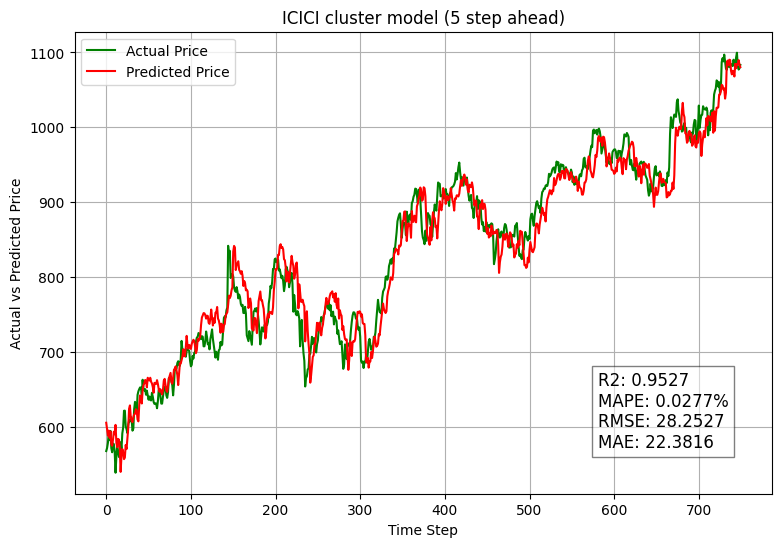

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('ICICI cluster model (5 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('ICICIcluster_5sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9799
MAPE: 0.0445
RMSE: 15.2385
RMSE_normalizeddata: 0.0145
MAE_normalizeddata: 0.0102
MAE: 10.7577


In [130]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9016e-04 - val_loss: 0.0026
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2751e-04 - val_loss: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6256e-04 - val_loss: 8.7204e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4445e-04 - val_loss: 8.8330e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4398e-04 - val_loss: 0.0015
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8139e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0368e-04 - val_loss: 0.0017
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7975e-04 - val_loss: 0.0014
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7098e-04 - val_loss: 0.0019
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2779e-04 - val_loss: 

In [131]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [132]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0213e-04 - val_loss: 0.0019
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1234e-04 - val_loss: 9.3799e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6019e-04 - val_loss: 0.0053
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6411e-04 - val_loss: 8.8867e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4501e-04 - val_loss: 9.2236e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5733e-04 - val_loss: 0.0012
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3645e-04 - val_loss: 0.0025
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4755e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7977e-04 - val_loss: 0.0013
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6425e-04 - val

In [133]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [134]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8744e-04 - val_loss: 0.0058
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2715e-04 - val_loss: 0.0013
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7626e-04 - val_loss: 9.5293e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7334e-04 - val_loss: 0.0013
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4751e-04 - val_loss: 8.4199e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6423e-04 - val_loss: 9.5743e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8087e-04 - val_loss: 0.0047
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5223e-04 - val_loss: 0.0023
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2665e-04 - val_loss: 0.0027
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2174e-04 - 

In [135]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [136]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.3501e-04 - val_loss: 0.0015
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0772e-04 - val_loss: 0.0011
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6316e-04 - val_loss: 0.0028
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6069e-04 - val_loss: 0.0024
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6563e-04 - val_loss: 0.0023
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6827e-04 - val_loss: 0.0025
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3959e-04 - val_loss: 9.0093e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6568e-04 - val_loss: 0.0010
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8696e-04 - val_loss: 0.0016
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2272e-04 - va

In [137]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [138]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.6038e-04 - val_loss: 0.0018
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0009e-04 - val_loss: 0.0014
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8050e-04 - val_loss: 0.0015
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8592e-04 - val_loss: 9.7622e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7034e-04 - val_loss: 0.0016
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3918e-04 - val_loss: 7.7740e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5750e-04 - val_loss: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4267e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4914e-04 - val_loss: 0.0016
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4199e-04 -

In [139]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [140]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.2494e-04 - val_loss: 9.8867e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.1338e-04 - val_loss: 0.0012
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7870e-04 - val_loss: 0.0051
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6828e-04 - val_loss: 0.0014
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7217e-04 - val_loss: 0.0015
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3342e-04 - val_loss: 0.0017
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.7574e-04 - val_loss: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.3822e-04 - val_loss: 0.0015
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.6519e-04 - val_loss: 0.0046
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.1476e-04 - va

In [141]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [142]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.1603e-04 - val_loss: 0.0011
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3440e-04 - val_loss: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4683e-04 - val_loss: 0.0012
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.5920e-04 - val_loss: 9.3230e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3393e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.2374e-04 - val_loss: 0.0012
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5994e-04 - val_loss: 8.8770e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.1775e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4319e-04 - val_loss: 0.0023
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3376e-04 

In [143]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [144]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2665e-04 - val_loss: 0.0039
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7213e-04 - val_loss: 0.0048
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7155e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5208e-04 - val_loss: 0.0011
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4811e-04 - val_loss: 0.0038
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6245e-04 - val_loss: 9.9306e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5250e-04 - val_loss: 0.0011
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3224e-04 - val_loss: 9.4712e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5623e-04 - val_loss: 9.4159e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2605e

In [145]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [146]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.1330e-04 - val_loss: 0.0011
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6674e-04 - val_loss: 0.0020
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8390e-04 - val_loss: 0.0023
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2347e-04 - val_loss: 0.0018
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5601e-04 - val_loss: 0.0019
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6633e-04 - val_loss: 0.0016
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7784e-04 - val_loss: 9.1774e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4051e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3251e-04 - val_loss: 9.5598e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1838e-04 - va

In [147]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")

In [148]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.0050e-04 - val_loss: 0.0011
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.5071e-04 - val_loss: 9.4750e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.6263e-04 - val_loss: 0.0018
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8723e-04 - val_loss: 0.0015
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.1430e-04 - val_loss: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.8434e-04 - val_loss: 9.0808e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.4221e-04 - val_loss: 0.0011
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.6559e-04 - val_loss: 0.0022
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.2052e-04 - val_loss: 0.0017
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.5890e-04 

In [149]:
model_lstm.save(f"model_lstm_icici5h_{r2:.4f}.keras")